In [15]:
# import packages for linear regression analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import re

In [16]:
# import csv file and create a datframe
df = pd.read_csv('ao3_lockwood_and_co_ao_12052023_1200.csv')

In [17]:
df.columns

Index(['link', 'title', 'author', 'published', 'updatedate', 'chapters',
       'language', 'words', 'kudos', 'comments', 'bookmarks', 'hits',
       'warning', 'mainship', 'relationship', 'characters', 'tags', 'summary',
       'rating', 'series', 'chapter', 'chapter_max', 'completion',
       'currentdate', 'datediff_pub', 'datediff', 'classification',
       'lastauthorupdate', 'firstauthorupdate', 'author_lastupdate_diff',
       'daysactive', 'daysincefirtupload', 'author_activity',
       'num_relationship', 'num_characters', 'num_tags'],
      dtype='object')

In [18]:
# check the data type of each column
df.dtypes

link                       object
title                      object
author                     object
published                  object
updatedate                 object
chapters                   object
language                   object
words                      object
kudos                      object
comments                    int64
bookmarks                   int64
hits                       object
warning                    object
mainship                   object
relationship               object
characters                 object
tags                       object
summary                    object
rating                     object
series                     object
chapter                     int64
chapter_max                object
completion                 object
currentdate                object
datediff_pub              float64
datediff                  float64
classification             object
lastauthorupdate           object
firstauthorupdate          object
author_lastupd

In [19]:
# remove the commas from the numbers in the columns words, chapters, comments, kudos, bookmarks, and hits
df['words'] = df['words'].str.replace(',', '')
df['kudos'] = df['kudos'].str.replace(',', '')
df['hits'] = df['hits'].str.replace(',', '')
# change the datatype to int for the columns words, chapters, comments, kudos, bookmarks, and hits
df['words'] = df['words'].astype(int)
df['kudos'] = df['kudos'].astype(int)
df['hits'] = df['hits'].astype(int)

In [20]:
# Create a wordsperchapter column that is the number of words in each chapter
df['wordsperchapter'] = df.apply(lambda row: row['words'] / row['chapter'], axis=1)
# Create a hitsperchapter column that is the number of hits in each chapter
df['hitsperchapter'] = df.apply(lambda row: row['hits'] / row['chapter'], axis=1)
# Create a commentsperchapter column that is the number of comments in each chapter
df['commentsperchapter'] = df.apply(lambda row: row['comments'] / row['chapter'], axis=1)
# Create a weekday column that is the day of the week in weekday name the story was updated (updatedate column)
df['weekday'] = pd.to_datetime(df['updatedate']).dt.day_name()

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='wordsperchapter', ylabel='Density'>

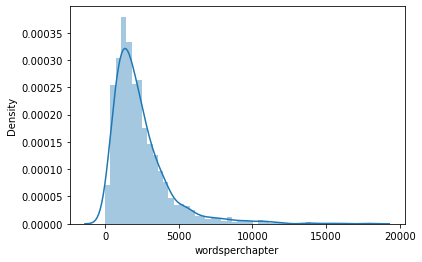

In [21]:
# show the distribution of the following variables and check which variables follows a normal distribution: wordsperchapter, chapter, hitsperchapter, kudos, commentsperchapter and bookmarks
sns.distplot(df['wordsperchapter'])
# wordsperchapter does not follow a normal distribution

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='chapter', ylabel='Density'>

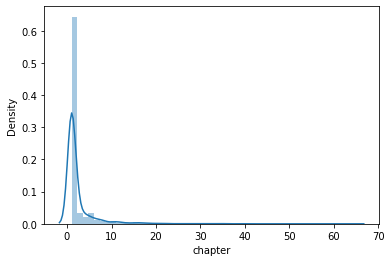

In [22]:
sns.distplot(df['chapter'])
# chapter does not follow a normal distribution

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hitsperchapter', ylabel='Density'>

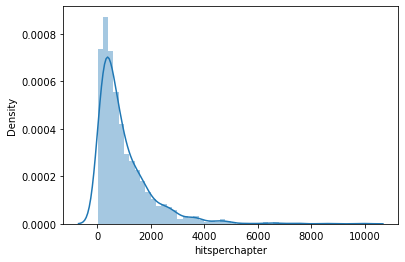

In [23]:
sns.distplot(df['hitsperchapter'])
# the hitsperchapter variable follows a normal distribution

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='kudos', ylabel='Density'>

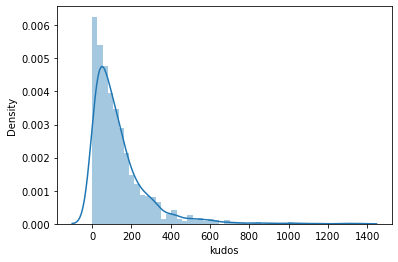

In [24]:
sns.distplot(df['kudos'])
# the kudos variable follows a normal distribution

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='commentsperchapter', ylabel='Density'>

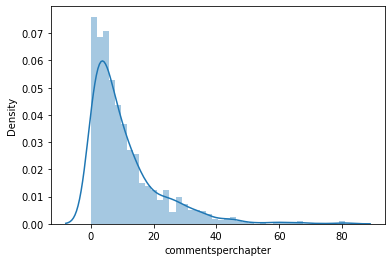

In [25]:
sns.distplot(df['commentsperchapter'])
#

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bookmarks', ylabel='Density'>

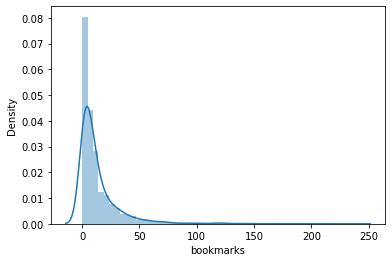

In [26]:
sns.distplot(df['bookmarks'])
# the bookmarks variable follows a normal distribution

In [27]:
# create a new column in df_corr that classify the correlation as very weak, weak, moderate, strong, or very strong
def classify_corr(corr):
    if corr > 0.8:
        return 'very strong'
    elif corr > 0.6:
        return 'strong'
    elif corr > 0.4:
        return 'moderate'
    elif corr > 0.2:
        return 'weak'
    else:
        return 'very weak'
# Function to calculate correlation and p-value
def calculate_corr_pvalue(corrMatrix):
    df_corr = pd.DataFrame(columns=['column1', 'column2', 'correlation', 'p-value'])

    for i in range(len(corrMatrix.columns)):
        for j in range(i + 1, len(corrMatrix.columns)):
            col1 = corrMatrix.columns[i]
            col2 = corrMatrix.columns[j]
            corr, p = pearsonr(corrMatrix[col1], corrMatrix[col2])
            df_corr = df_corr.append({'column1': col1, 'column2': col2, 'correlation': corr, 'p-value': p}, ignore_index=True)
    # Apply classification to correlation
    df_corr['correlation_class'] = df_corr['correlation'].apply(classify_corr)
    return df_corr

In [28]:
CORRELATION_COLUMNS = ['wordsperchapter', 'chapter', 'words', 'hitsperchapter', 'kudos', 'commentsperchapter', 'bookmarks']
df_corr = calculate_corr_pvalue(df[CORRELATION_COLUMNS])
df_corr

,column1,column2,correlation,p-value,correlation_class
0,wordsperchapter,chapter,-0.030669,2.385082e-01,very weak
1,wordsperchapter,words,0.280753,3.412974e-28,weak
2,wordsperchapter,hitsperchapter,0.202820,3.396888e-15,weak
3,wordsperchapter,kudos,0.181854,1.833388e-12,very weak
4,wordsperchapter,commentsperchapter,0.360040,1.701152e-46,weak
5,wordsperchapter,bookmarks,0.266237,2.034414e-25,weak
6,chapter,words,0.822376,0.000000e+00,very strong
7,chapter,hitsperchapter,-0.191640,1.063132e-13,very weak
8,chapter,kudos,0.214606,7.200355e-17,weak
9,chapter,commentsperchapter,-0.065385,1.189951e-02,very weak


In [29]:
def visualize_relationship_categorical_numeric(df, categorical_variable, numeric_variables):
    # Create subplots for boxplots
    fig, axes = plt.subplots(len(numeric_variables), figsize=(15, 15))

    # Iterate over numeric variables
    for i, numeric_var in enumerate(numeric_variables):
        # Create boxplot for each numeric variable grouped by the categorical variable
        sns.boxplot(ax=axes[i], x=categorical_variable, y=numeric_var, data=df, showfliers=False)

    # Display the plot
    plt.show()


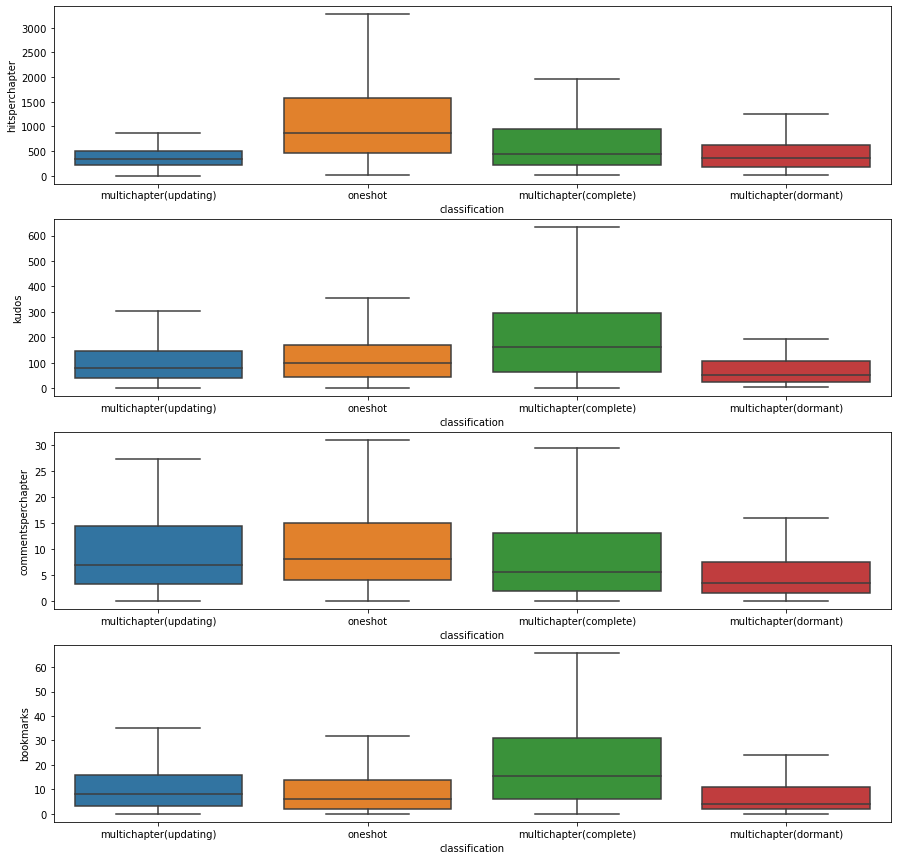

In [30]:
NUMERICAL_VARIABLES = ['hitsperchapter', 'kudos', 'commentsperchapter', 'bookmarks']
visualize_relationship_categorical_numeric(df, 'classification', NUMERICAL_VARIABLES)

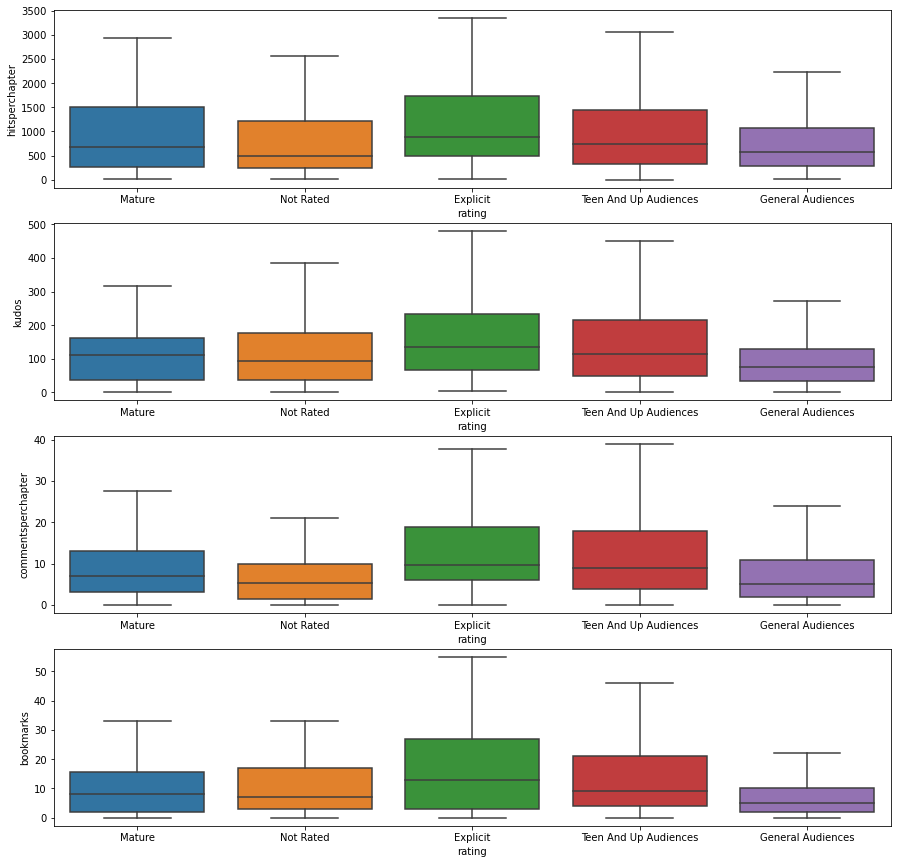

In [31]:
# create a multiplot boxplot to visualize the relationship between ratings and the numeric variables
visualize_relationship_categorical_numeric(df, 'rating', NUMERICAL_VARIABLES)

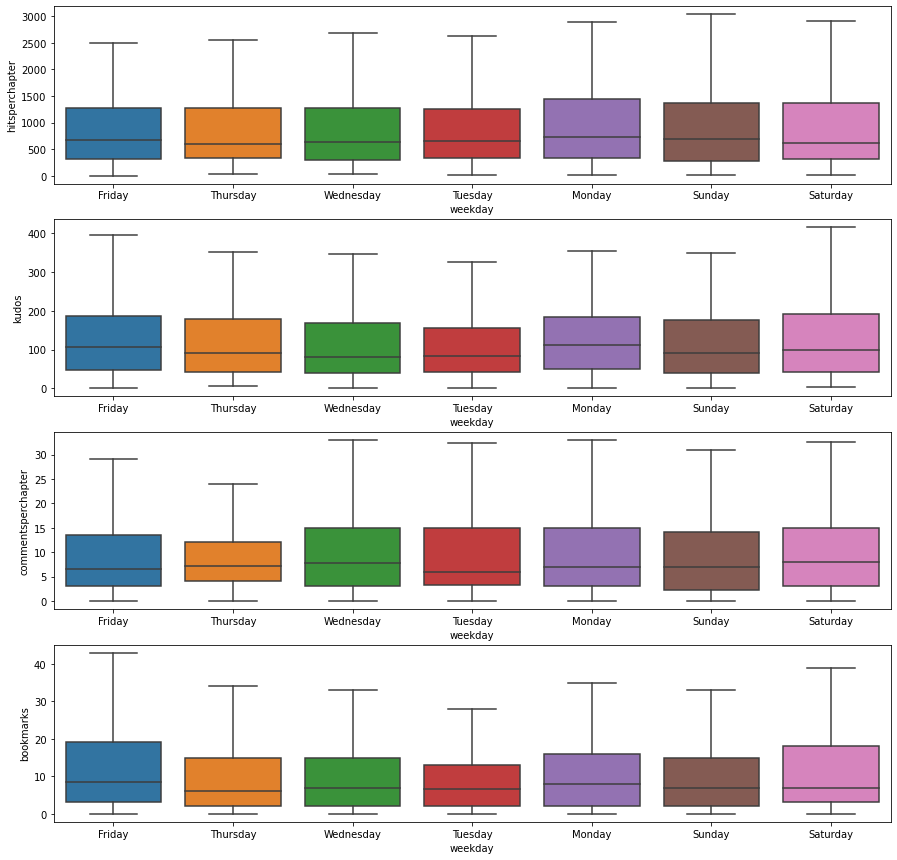

In [32]:
# create a multiplot boxplot to visualize the relationship between weekday and the numeric variables arranged by weekday
visualize_relationship_categorical_numeric(df, 'weekday', NUMERICAL_VARIABLES)

In [33]:
df['classification'].unique()

array(['multichapter(updating)', 'oneshot', 'multichapter(complete)',
       'multichapter(dormant)'], dtype=object)

In [34]:
oneshot = calculate_corr_pvalue(df[df['classification'] == 'oneshot'][CORRELATION_COLUMNS])
multicomp = calculate_corr_pvalue(df[df['classification'] == 'multichapter(complete)'][CORRELATION_COLUMNS])
multidorm = calculate_corr_pvalue(df[df['classification'] == 'multichapter(dormant)'][CORRELATION_COLUMNS])
multiupda = calculate_corr_pvalue(df[df['classification'] == 'multichapter(updating)'][CORRELATION_COLUMNS])
classification_df = oneshot[['column1', 'column2']]
classification_df['oneshot'] = oneshot['correlation_class']
classification_df['multicomp'] = multicomp['correlation_class']
classification_df['multidorm'] = multidorm['correlation_class']
classification_df['multiupda'] = multiupda['correlation_class']
classification_df

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/tmp/ipykernel_30071/2688778654.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['oneshot'] = oneshot['correlation_class']
/tmp/ipykernel_30071/2688778654.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['multicomp'] = mu

,column1,column2,oneshot,multicomp,multidorm,multiupda
0,wordsperchapter,chapter,very weak,very weak,very weak,very weak
1,wordsperchapter,words,very strong,moderate,weak,moderate
2,wordsperchapter,hitsperchapter,weak,weak,very weak,very weak
3,wordsperchapter,kudos,weak,very weak,very weak,very weak
4,wordsperchapter,commentsperchapter,weak,weak,moderate,weak
5,wordsperchapter,bookmarks,weak,weak,very weak,weak
6,chapter,words,very weak,strong,very strong,very strong
7,chapter,hitsperchapter,very weak,very weak,very weak,very weak
8,chapter,kudos,very weak,very weak,moderate,moderate
9,chapter,commentsperchapter,very weak,very weak,very weak,very weak


In [35]:
df['rating'].unique()

array(['Mature', 'Not Rated', 'Explicit', 'Teen And Up Audiences',
       'General Audiences'], dtype=object)

In [36]:
ga = calculate_corr_pvalue(df[df['rating'] == 'General Audiences'][CORRELATION_COLUMNS])
te = calculate_corr_pvalue(df[df['rating'] == 'Teen And Up Audiences'][CORRELATION_COLUMNS])
ma = calculate_corr_pvalue(df[df['rating'] == 'Mature'][CORRELATION_COLUMNS])
ex = calculate_corr_pvalue(df[df['rating'] == 'Explicit'][CORRELATION_COLUMNS])
rating_df = ga[['column1', 'column2']]
rating_df['General Audiences'] = ga['correlation_class']
rating_df['Teen And Up Audiences'] = te['correlation_class']
rating_df['Mature'] = ma['correlation_class']
rating_df['Explicit'] = ex['correlation_class']
rating_df

/tmp/ipykernel_30071/538722368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['General Audiences'] = ga['correlation_class']
/tmp/ipykernel_30071/538722368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['Teen And Up Audiences'] = te['correlation_class']


,column1,column2,General Audiences,Teen And Up Audiences,Mature,Explicit
0,wordsperchapter,chapter,very weak,very weak,very weak,very weak
1,wordsperchapter,words,moderate,weak,weak,very weak
2,wordsperchapter,hitsperchapter,very weak,weak,very weak,very weak
3,wordsperchapter,kudos,very weak,very weak,very weak,very weak
4,wordsperchapter,commentsperchapter,weak,weak,weak,moderate
5,wordsperchapter,bookmarks,weak,weak,weak,very weak
6,chapter,words,strong,very strong,very strong,very strong
7,chapter,hitsperchapter,very weak,very weak,very weak,very weak
8,chapter,kudos,very weak,very weak,weak,moderate
9,chapter,commentsperchapter,very weak,very weak,very weak,very weak


In [37]:
CORRELATION_COLUMNS = ['num_relationship', 'hitsperchapter', 'kudos', 'commentsperchapter', 'bookmarks']
df_corr = calculate_corr_pvalue(df[CORRELATION_COLUMNS])
df_corr

,column1,column2,correlation,p-value,correlation_class
0,num_relationship,hitsperchapter,0.039225,1.315995e-01,very weak
1,num_relationship,kudos,0.051139,4.926306e-02,very weak
2,num_relationship,commentsperchapter,0.088215,6.829781e-04,very weak
3,num_relationship,bookmarks,0.033932,1.921612e-01,very weak
4,hitsperchapter,kudos,0.656879,2.361566e-183,strong
5,hitsperchapter,commentsperchapter,0.489959,3.815293e-90,moderate
6,hitsperchapter,bookmarks,0.542323,7.453851e-114,moderate
7,kudos,commentsperchapter,0.639420,8.037934e-171,strong
8,kudos,bookmarks,0.933547,0.000000e+00,very strong
9,commentsperchapter,bookmarks,0.613031,2.356090e-153,strong


In [38]:
CORRELATION_COLUMNS = ['num_characters', 'hitsperchapter', 'kudos', 'commentsperchapter', 'bookmarks']
df_corr = calculate_corr_pvalue(df[CORRELATION_COLUMNS])
df_corr

,column1,column2,correlation,p-value,correlation_class
0,num_characters,hitsperchapter,-0.161139,4.587908e-10,very weak
1,num_characters,kudos,-0.009537,7.140052e-01,very weak
2,num_characters,commentsperchapter,-0.034903,1.797363e-01,very weak
3,num_characters,bookmarks,0.062426,1.634720e-02,very weak
4,hitsperchapter,kudos,0.656879,2.361566e-183,strong
5,hitsperchapter,commentsperchapter,0.489959,3.815293e-90,moderate
6,hitsperchapter,bookmarks,0.542323,7.453851e-114,moderate
7,kudos,commentsperchapter,0.639420,8.037934e-171,strong
8,kudos,bookmarks,0.933547,0.000000e+00,very strong
9,commentsperchapter,bookmarks,0.613031,2.356090e-153,strong


In [39]:
CORRELATION_COLUMNS = ['num_tags', 'hitsperchapter', 'kudos', 'commentsperchapter', 'bookmarks']
df_corr = calculate_corr_pvalue(df[CORRELATION_COLUMNS])
df_corr

,column1,column2,correlation,p-value,correlation_class
0,num_tags,hitsperchapter,-0.140506,5.765791e-08,very weak
1,num_tags,kudos,0.026430,3.097492e-01,very weak
2,num_tags,commentsperchapter,0.009006,7.292925e-01,very weak
3,num_tags,bookmarks,0.081367,1.737822e-03,very weak
4,hitsperchapter,kudos,0.656879,2.361566e-183,strong
5,hitsperchapter,commentsperchapter,0.489959,3.815293e-90,moderate
6,hitsperchapter,bookmarks,0.542323,7.453851e-114,moderate
7,kudos,commentsperchapter,0.639420,8.037934e-171,strong
8,kudos,bookmarks,0.933547,0.000000e+00,very strong
9,commentsperchapter,bookmarks,0.613031,2.356090e-153,strong


In [40]:
df.columns

Index(['link', 'title', 'author', 'published', 'updatedate', 'chapters',
       'language', 'words', 'kudos', 'comments', 'bookmarks', 'hits',
       'warning', 'mainship', 'relationship', 'characters', 'tags', 'summary',
       'rating', 'series', 'chapter', 'chapter_max', 'completion',
       'currentdate', 'datediff_pub', 'datediff', 'classification',
       'lastauthorupdate', 'firstauthorupdate', 'author_lastupdate_diff',
       'daysactive', 'daysincefirtupload', 'author_activity',
       'num_relationship', 'num_characters', 'num_tags', 'wordsperchapter',
       'hitsperchapter', 'commentsperchapter', 'weekday'],
      dtype='object')